# Austin Animal Center: Intakes and Outcomes

By: Johnathon Smith

Date: Oct 13, 2021
***

### Executive Summary
***

__Project Goal__

The goal of this project is to reduce the euthanization of healthy animals. Since the Austin Animal Center only euthanizes healthy animals when the shelter is full, I performed time-series analysis on the number of animal intakes since October 1st, 2013. By searching for trends and repetitive cycles, I had hoped to provide recommendations to keep the shelter from reaching max capacity.

__Overall Findings__

* A cyclic trend definitely exists for animal intakes and adoptions. The euthanization rate has slowly decreased over time.
* At the start of the Covid-19 pandemic in early 2020, there was a sharp decline in numbers for all categories other than number of euthanizations. Since that time, numbers for those categories have started to rise again.
* Animal intake and adoption counts are expected to continue rising and return to pre-pandemic numbers. 

__Recommendations__

To minimize the euthanization of healthy animals, I recommend:

* Transferring eligible animals currently housed at the shelter to other 'No-Kill' shelters in the Austin area.
* Promoting and encouraging adoptions with a strong marketing plan.
* Promoting and encouraging the fostering of animals.

The purpose of these recommendations is to reduce the number of animals currently housed at the shelter. This will help prevent the rising number of animal intakes from overwhelming the Austin Animal Center and reduce the risk of having to euthanize healthy animals.
***

### My Process

* Write a README.md file that details my process, my findings, and instructions on how to recreate my project.
* Acquire the Ausin Animal Center data from the Austin Open Data Portal.
* Clean and prepare the Austin Animal Center data:
    * There are two different data sets I had to use: Intakes and Outcomes
    * Prepare each individually
    * Create a common datetime index between the two of them
    * Merge them together
* Plot individual variable distributions
* Explore the data and look for long term trends and cyclic behavior.
* Set baseline using the Simple Average.
* Create and evaluate models on train and validate sets.
* Choose best model and evaluate it on test data set.
* Document conclusions, takeaways, and next steps in the Final Report Notebook.
***

### Necessary Imports

In [1]:
import numpy as np
import pandas as pd

#Custom modules
import wrangle
import explore
import model

### Acquire
***

__Data Dictionary__

| Feature | Datatype | Definition |
|:--------|:---------|:------------|
| intakes | int | The number of animals received by the Austin Animal Center|
| adoptions | int | The number of animals adopted from the Austin Animal Center |
| euthanizations | int | The number of animals (Healthy or otherwise) euthanized at the Austin Animal Center |
| transfers | int | The number of animals transferred to partner programs or shelters in Austin |

__Wrangle the Data__

Since the Austin Animal Center data is updated on a daily basis, the datasets used for this project will be provided as .csv files. To replicate this project, please ensure that they have been downloaded to your working directory.

In [2]:
#This function call will acquire and prepare the datasets for use in this project
events = wrangle.get_event_data()

In [3]:
#Provide a brief overview of the prepared dataframe
events.head()

,intakes,adoptions,euthanizations,transfers
Date,,,,
2013-10-01,77,11,10,17
2013-10-02,53,16,5,31
2013-10-03,42,10,4,17
2013-10-04,47,11,3,5
2013-10-05,67,36,4,18


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2932 entries, 2013-10-01 to 2021-10-10
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   intakes         2932 non-null   int64
 1   adoptions       2932 non-null   uint8
 2   euthanizations  2932 non-null   uint8
 3   transfers       2932 non-null   uint8
dtypes: int64(1), uint8(3)
memory usage: 54.4 KB


In [5]:
events.describe()

,intakes,adoptions,euthanizations,transfers
count,2932.000000,2932.000000,2932.000000,2932.000000
mean,45.095498,20.419850,3.007503,13.174284
std,18.024768,12.855311,2.743177,9.417674
min,0.000000,0.000000,0.000000,0.000000
25%,34.000000,13.000000,1.000000,6.000000
50%,45.000000,19.000000,2.000000,11.000000
75%,56.000000,26.000000,4.000000,18.000000
max,140.000000,197.000000,30.000000,91.000000


__Key Takeaways__

* The final dataframe is a combination of two different datasets, one for intakes and the other for outcomes.
* To prepare the Intakes dataset, I had to create a new column called 'intakes', convert the 'DateTime' column to a datetime object and set it as the index.
* To prepare the Outcomes dataset, I had to create a new column for each value of 'Outcome Type'. To do this, I created dummy variables for the original column and then removed it. I also converted the 'DateTime' column to a datetime object and set it as the index.
* After dropping all unnecessary columns from both datasets, I merged them together on the common datetime index, resampled by day, and took the sum of the values.

__Individual Variable Distributions__

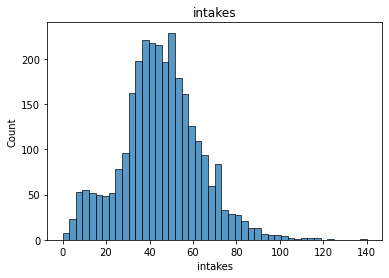

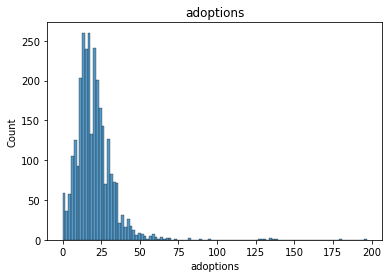

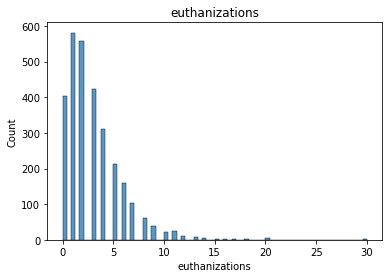

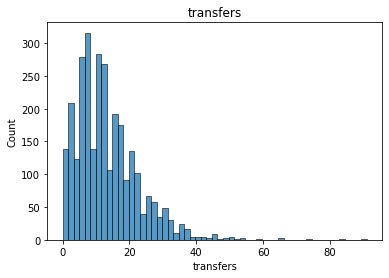

In [6]:
#The following function call plots the individual varaible distributions
wrangle.get_dists(events)

### To Split, or Not to Split?

Normally, before progressing to the exploration stage, I would split the data into train, validate, and test sets so that I could explore only on the train set. However, due to the unusual effect of the Covid-19 pandemic in early 2020 and beyond, I decided it would be best to explore the entire dataset, so that I could take this unusual behavior into account when creating my models. The dataset will be split into train, validate, and test sets upon entering the modeling and evaluation stages.
***

### Explore

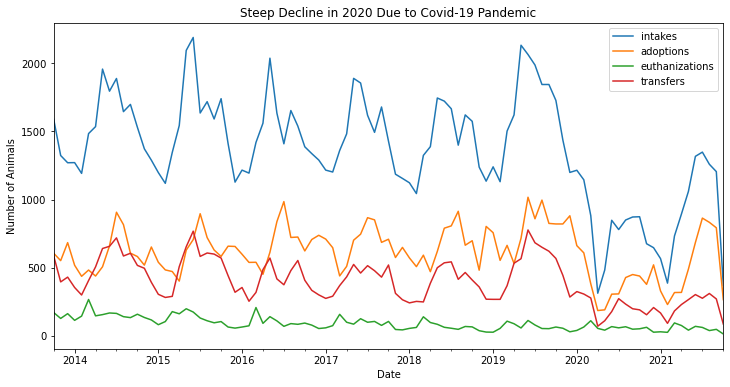

In [7]:
#The following function call plots the count of each variable per month over time
explore.plot_events(events)

__Key Takeaway__

The Covid-19 pandemic resulted in a steep decline of animal intakes, adoptions, and transfers in early 2020. Euthanization rate appears to have remained about constant.

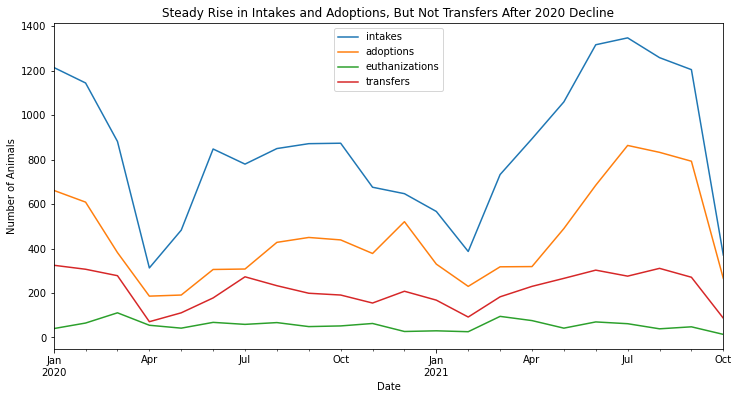

In [8]:
#The following function call plots the period after the steep decline in 2020
explore.plot_events_post_pandemic(events)

__Key Takeaway__

Since the steep decline in early 2020, the number of animal intakes and adoptions have steadily increased. However, the number of transfers and euthanizations has remained about the same.

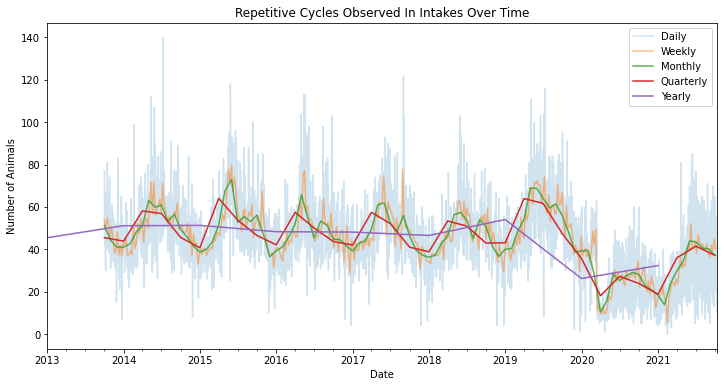

In [9]:
#The following function call plots the trend of animal intakes over time
explore.plot_intake_trends(events)

__Key Takeaway__

The cyclic behavior observed above suggests that predicting future numbers using the previous cycle may be a good choice here.

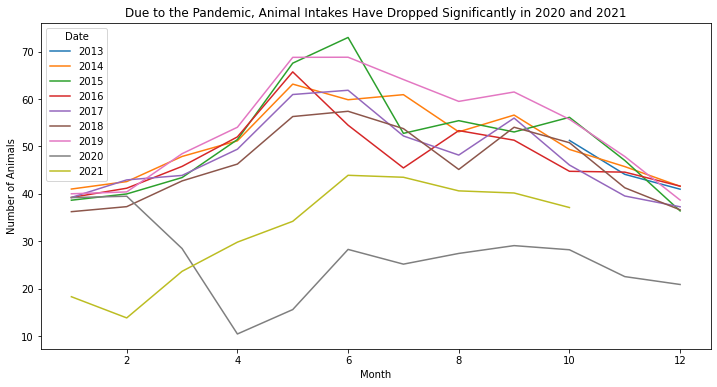

In [10]:
# The following function call compares the yearly plots of each group
explore.plot_yearly_intake_trends(events)

__Key Takeaway__

As expected, the seasonal plot above shows that the number of animal intakes dropped significantly after the Covid-19 pandemic began. Unitl then, the number of animal intakes had been about the same since 2013.
***

### Model and Evaluate

Now I will split the data into train, validate, and test data sets. It was difficult to decide how to do it, thanks to the unusual behavior after the pandemic hit, but I tried to divide the data in a way that would allow me to capture the cyclic behavior as well as the period of steep decline and following increase.

Train will be nearly everything before Apr 2020.

In [11]:
train = events['2014-04':'2020-03'].resample('M').sum()
train.shape

(72, 4)

Validate will be the data between Apr 2020 and Apr 2021.

In [12]:
validate = events['2020-04':'2021-03'].resample('M').sum()
validate.shape

(12, 4)

Test will be the dates from Apr 2021 to Oct 2021

In [13]:
test = events['2021-04':'2021-10'].resample('M').sum()
test.shape

(7, 4)

Below, you can see how the data sets connect to one another.

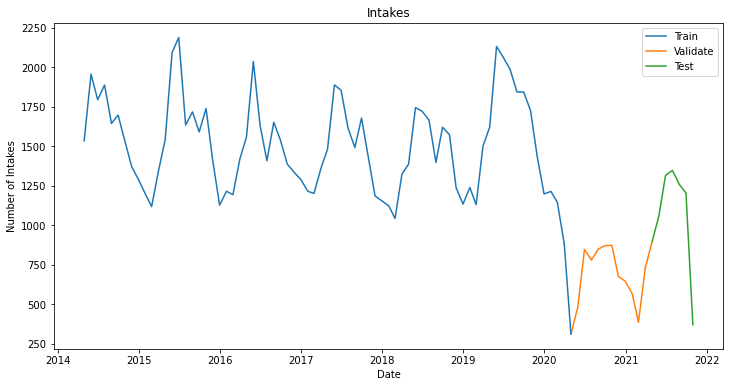

In [14]:
#The following function call plots intakes from the train, validate, and test sets together
model.plot_train_validate_test(train, validate, test, events)

__Evaluation DataFrame__

Before continuing, I need to create a dataframe to store the results of each of my models, including the baseline.

In [15]:
#Create an evaluation dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

__Setting the Baseline__

To set the baseline, I will use the simple average of the train data set.

intakes -- RMSE: 860


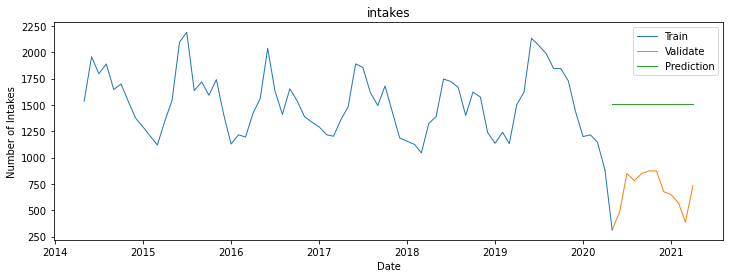

,model_type,target_var,rmse
0,simple_average,intakes,860.0


In [16]:
eval_df = model.get_simple_average(train, validate, events, eval_df)
eval_df

__Moving Average__

Next, I will create 1, 3, 6, 9, and 12 month moving average models.

In [17]:
eval_df = model.get_moving_average(train, validate, events, eval_df)
eval_df

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0


__Holt's Model__

The following model will attempt to take into account the positive trend after the 2020 decline.

intakes -- RMSE: 187


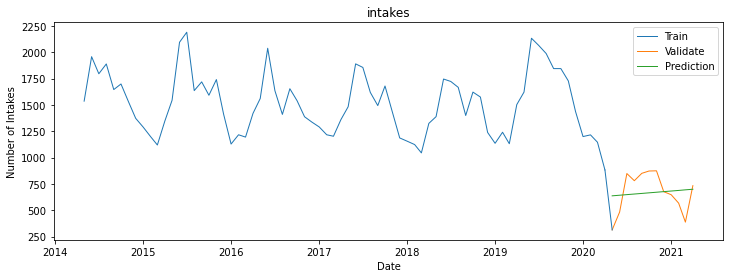

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0
6,Holts,intakes,187.0


In [18]:
eval_df = model.get_holts_model(train, validate, events, eval_df)
eval_df

__Predict Using Previous Cycles__

The following model will calculate the average yearly difference and apply it to the validate index. It will also attempt to account for the sudden drop due to the pandemic in 2020 by adding the average difference between the last two years of the train data set.

intakes -- RMSE: 530


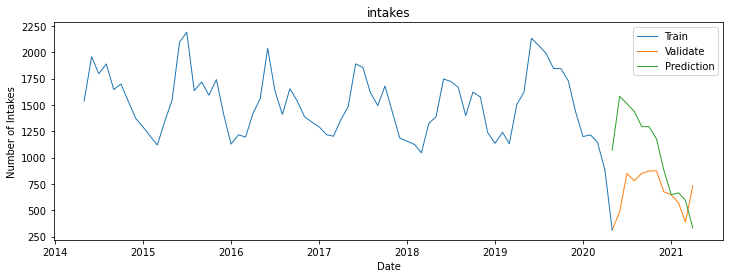

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0
6,Holts,intakes,187.0
7,previous year plus delta,intakes,530.0


In [19]:
eval_df = model.get_previous_cycle_model(train, validate, events, eval_df)
eval_df

***
### Choose Best Model

My best model will be chosen based on the RMSE. The one with the lowest RMSE will be evaluated on the unseen test data set. 

In [20]:
#The following code will organize the eval_df by rmse and show the entry with the lowest value
eval_df.sort_values(by = 'rmse', ascending = False).tail(1)

,model_type,target_var,rmse
6,Holts,intakes,187.0


Although I believe that using a model based on the previous cycles would be best, the lowest RMSE is for my Holt's Linear Trend model.
***

### Evaluate on Test

To evaluate my best model on test, I will create a new eval_df called test_eval to store the results and then call the appropriate function.

In [21]:
#Create new eval df
test_eval = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

intakes -- RMSE: 471


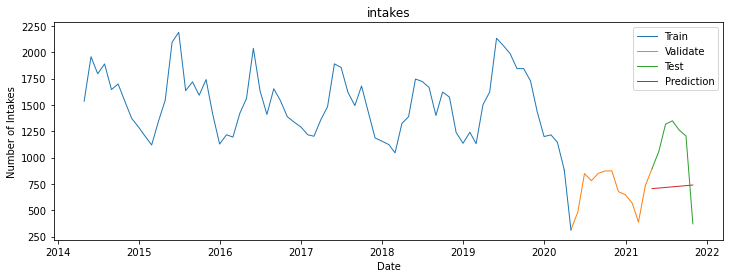

,model_type,target_var,rmse
0,Holts,intakes,471.0


In [22]:
#The following function call will evaluate the Holt's model on the unseen test data
test_eval = model.eval_holts_model_on_test(train, validate, test, events, test_eval)
test_eval

***
### Conclusion

__Overall Findings__

* A cyclic trend definitely exists for animal intakes and adoptions. The euthanization rate has slowly decreased over time.
* At the start of the Covid-19 pandemic in early 2020, there was a sharp decline in numbers for all categories other than number of euthanizations. Since that time, numbers for those categories have started to rise again.
* Animal intake and adoption counts are expected to continue rising and return to pre-pandemic numbers. 

__Recommendations__

To minimize the euthanization of healthy animals, I recommend:

* Transferring eligible animals currently housed at the shelter to other 'No-Kill' shelters in the Austin area.
* Promoting and encouraging adoptions with a strong marketing plan.
* Promoting and encouraging the fostering of animals.

The purpose of these recommendations is to reduce the number of animals currently housed at the shelter. This will help prevent the rising number of animal intakes from overwhelming the Austin Animal Center and reduce the risk of having to euthanize healthy animals.
***

### With More Time...

If I had more time, I would have liked to experiment more with models based on the previous cycle. I believe something like that would have performed much better on test. It may even be best to use two different models: one for pre-pandemic numbers and another for post-pandemic numbers. I would also like to go back and make predictions on adoptions and euthanizations.